## Calculate Negative Selection returns and perform return analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import edhec_risk_kit as erk

In [2]:
# Name control files as well as relevant columns to process data
out_col_N = ['Date','Ticker','TR_1M','Neg_Sel','NS_Quintile']
control_N = pd.read_csv(r'C:\Users\B420615.STANLIB\Neg_Sel_Control.csv')
control_N = control_N['Files'].tolist()

In [3]:
# create file of negative selection alpha scores for all periods and output
Neg_Sel_Score = pd.DataFrame()
for file in control_N:
    try:
        data = pd.read_csv(rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\{file}.csv')
        Add_data = data[out_col_N].copy()
        Add_data['Date'] = Add_data['Date'].astype(int)
        Add_data['Date'] = pd.to_datetime(Add_data['Date'],format='%Y%m%d')
        Neg_Sel_Score = pd.concat([Neg_Sel_Score,Add_data],axis=0)
    
    except Exception as e:
        print(f"Error processing file {file}: {e}") 
       
#output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Neg_Sel_Alpha_Score.csv'
#Neg_Sel_Score.to_csv(output_file_path, index=False)

Error processing file Neg_Sel_SNS20250131: [Errno 2] No such file or directory: 'C:\\Users\\B420615.STANLIB\\OneDrive - Standard Bank\\Documents\\data\\Neg_Sel\\Neg_Sel_SNS20250131.csv'
Error processing file Neg_Sel_SNS20250228: [Errno 2] No such file or directory: 'C:\\Users\\B420615.STANLIB\\OneDrive - Standard Bank\\Documents\\data\\Neg_Sel\\Neg_Sel_SNS20250228.csv'


In [4]:
Neg_Sel_Score.head()

,Date,Ticker,TR_1M,Neg_Sel,NS_Quintile
0,2005-10-31,AU US Equity,-7.87,0.772106,5
1,2005-10-31,EMI SJ Equity,3.09,0.480093,5
2,2005-10-31,CML SJ Equity,-0.91,0.376373,5
3,2005-10-31,ELH SJ Equity,-7.30,0.197005,4
4,2005-10-31,HYP SJ Equity,2.72,0.422576,5


In [5]:
#Create a column that aligns future 1M returns with current selection (Future_TR)
Neg_Sel_Score['Future_TR'] = Neg_Sel_Score.groupby('Ticker')['TR_1M'].shift(-1)
Neg_Sel_Score = Neg_Sel_Score.sort_values(by=['Date'])
Alltime = list(set(Neg_Sel_Score['Date'])) # used set to eliminate duplicate values
output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Neg_Sel_Score.csv'
Neg_Sel_Score.to_csv(output_file_path, index=False)

In [6]:
Neg_Sel_Score.head()

,Date,Ticker,TR_1M,Neg_Sel,NS_Quintile,Future_TR
0,2005-10-31,AU US Equity,-7.87,0.772106,5,5.35
78,2005-10-31,RLO SJ Equity,9.22,1.011513,5,10.87
77,2005-10-31,DTC SJ Equity,-4.30,-0.006024,3,13.53
76,2005-10-31,SAB SJ Equity,0.80,0.148841,4,-5.31
75,2005-10-31,TKG SJ Equity,0.48,0.259848,5,3.98


In [7]:
#Create a "liquid portfolio to eliminate illiquid stocks (defined by mkt cap). 
#Merge the liquidity filter dataframe and eliminate rows that do not meet liquidity requirements
liquidity_filter = 0.25
Jalsh_wts = pd.read_csv(rf'C:\Users\B420615.STANLIB\JalshWeightsBBG.csv')
Jalsh_wts["Date"] = pd.to_datetime(Jalsh_wts["Date"])
Jalsh_wts.rename(columns={'ID':'Ticker'},inplace=True)
Jalsh_wts.head()


Neg_Sel_Score_liquid = Neg_Sel_Score.merge(Jalsh_wts, on=['Date','Ticker'],how='left')
Neg_Sel_Score_liquid.drop(Neg_Sel_Score_liquid[Neg_Sel_Score_liquid['id().weights'] < liquidity_filter].index, inplace = True)


output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Neg_Sel_Score_liquid.csv'
Neg_Sel_Score_liquid.to_csv(output_file_path, index=False)



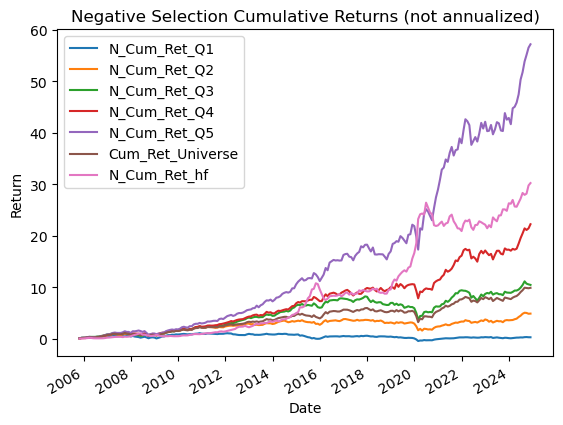

In [8]:
# Split data into quintiles, calculate quintile returns and graph quintile/universe performance - for Sentimentcomponent
averages = Neg_Sel_Score.groupby(['Date', 'NS_Quintile'])['Future_TR'].mean().unstack(fill_value=0)
averages.reset_index(inplace=True)
averages.columns.name = None
averages.columns = ['Date','N_Q1','N_Q2','N_Q3','N_Q4','N_Q5']
Universe = Neg_Sel_Score.groupby(['Date'])['Future_TR'].mean()
averages = pd.merge(averages, Universe, on='Date', how='outer')
averages.rename(columns={'Future_TR':'Universe'},inplace=True)
averages['N_hf_returns'] = averages['N_Q5'] - averages['N_Q1']
averages['N_Cum_Ret_Q1'] = (1+averages['N_Q1']/100).cumprod()-1
averages['N_Cum_Ret_Q2'] = (1+averages['N_Q2']/100).cumprod()-1
averages['N_Cum_Ret_Q3'] = (1+averages['N_Q3']/100).cumprod()-1
averages['N_Cum_Ret_Q4'] = (1+averages['N_Q4']/100).cumprod()-1
averages['N_Cum_Ret_Q5'] = (1+averages['N_Q5']/100).cumprod()-1
averages['Cum_Ret_Universe'] = (1+averages['Universe']/100).cumprod()-1
averages['N_Cum_Ret_hf'] = ((1+averages['N_hf_returns']/100).cumprod()-1)

ax = averages.plot(xlabel='Date', ylabel='Return',x = 'Date',y = ['N_Cum_Ret_Q1','N_Cum_Ret_Q2','N_Cum_Ret_Q3','N_Cum_Ret_Q4','N_Cum_Ret_Q5','Cum_Ret_Universe','N_Cum_Ret_hf'])
ax.set_title('Negative Selection Cumulative Returns (not annualized)')

# Create a dataframe of average returns to be used to calculate the IC score
Ave_returns = averages[['Date', 'Universe']].copy()
# Create output file
output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Neg_Sel_Q_Scores.csv'
averages.to_csv(output_file_path, index=False)

In [9]:
#Create portfolios that include costs, interest plus liquidity filters

In [10]:
#Show annualised returns
last_row_series = ((1+(averages.iloc[-2][['N_Cum_Ret_Q1','N_Cum_Ret_Q2','N_Cum_Ret_Q3','N_Cum_Ret_Q4',
                                         'N_Cum_Ret_Q5','Cum_Ret_Universe','N_Cum_Ret_hf']]))**(12/229)-1)*100
last_row_series
#fig,ax = plt.subplots(figsize = (10,8))
#returns = sns.barplot(y = last_row_series,x = , color = sns.color_palette()[0],saturation=1.)

N_Cum_Ret_Q1         1.217841
N_Cum_Ret_Q2         9.706456
N_Cum_Ret_Q3        13.621657
N_Cum_Ret_Q4         17.91882
N_Cum_Ret_Q5          23.7332
Cum_Ret_Universe    13.318715
N_Cum_Ret_hf         19.76137
Name: 228, dtype: object

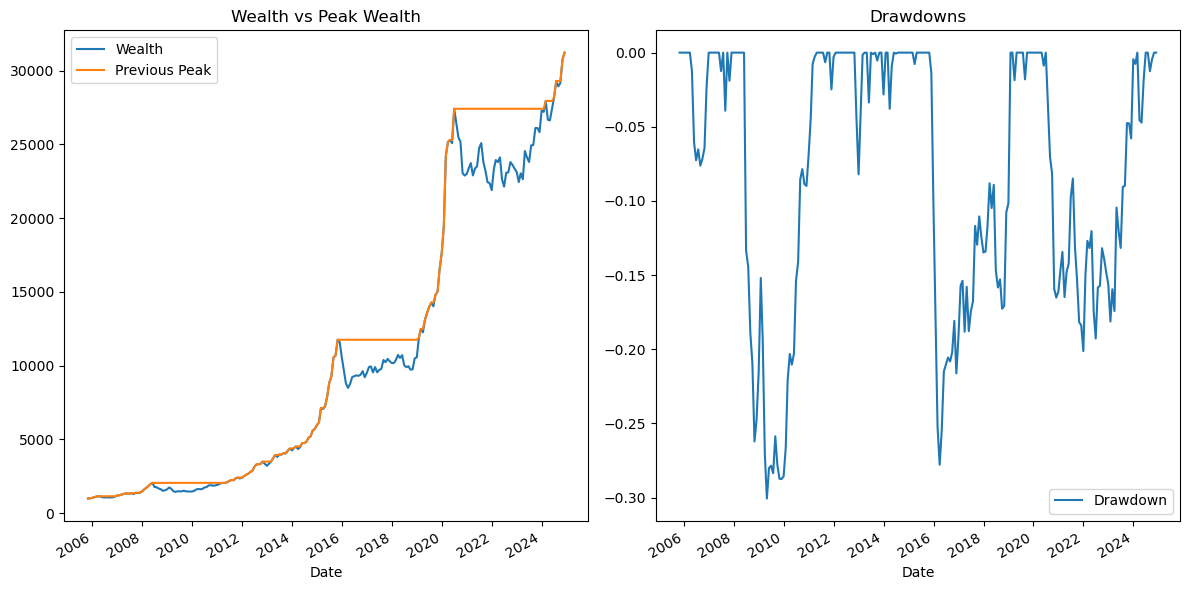

In [11]:
#Calculate drawdowns
Drawdowns = erk.drawdown(averages['N_hf_returns']/100)
Drawdowns = pd.merge(Drawdowns, averages['Date'], left_index=True,right_index=True)
Drawdowns = Drawdowns.reindex(['Date', 'Wealth', 'Previous Peak','Drawdown'], axis=1)
Drawdowns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
Drawdowns.plot(x='Date',y=['Wealth','Previous Peak'],ax=axes[0])
axes[0].set_title('Wealth vs Peak Wealth')

Drawdowns.plot(x='Date',y='Drawdown',ax=axes[1])
axes[1].set_title('Drawdowns')

plt.tight_layout()
plt.show()
                  
#ax = Drawdowns.plot(xlabel='Months', ylabel='Wealth',x='Date',y = ['Wealth','Previous Peak'])
#ax.set_title('Wealth vs Peak Wealth')


In [12]:
# Sharpe Ratio
erk.sharpe_ratio(averages['N_hf_returns']/100, 0, 12)

1.2719336232306053

In [13]:
#Isolate the Short portfolio through time - output 'Shorts' file
filtered_df = pd.DataFrame()
for date in Alltime:
    #Filter rows for the date and specified integer value
    temp_df = Neg_Sel_Score[(Neg_Sel_Score['Date'] == date) & (Neg_Sel_Score['NS_Quintile'] == 1) ]
    filtered_df = pd.concat([filtered_df, temp_df], ignore_index=True)
    filtered_df = filtered_df.sort_values(by=['Date'])

output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Shorts.csv'
filtered_df.to_csv(output_file_path, index=False)

In [14]:
def count_items_exceeding_value(df1, df2, date_column, value_column_df1, value_column_df2):
    """
    Counts the number of items in df1[value_column_df1] for each date
    that exceed the value of a single row item for the same date in df2[value_column_df2].

    """

    # Initialize an empty dictionary to store the counts
    counts = {}

    # Iterate through each date in the first DataFrame
    for date in df1[date_column].unique():
        # Filter the first DataFrame for the current date
        df1_date = df1[df1[date_column] == date]

        # Filter the second DataFrame for the current date
        df2_date = df2[df2[date_column] == date]

        # Ensure that there is a corresponding date in the second DataFrame
        if not df2_date.empty:
            # Get the value from the second DataFrame for the current date
            value_df2 = df2_date[value_column_df2].iloc[0]

            # Count the number of items in the first DataFrame that exceed the value from the second DataFrame
            count = (df1_date[value_column_df1] > value_df2).sum()

            # Store the count in the dictionary
            counts[date] = count
        else:
            counts[date] = 0

    # Convert the dictionary to a Pandas Series
    return pd.Series(counts)


In [15]:
#Calculate ic score for Shorts (Sentiment)
Shorts = pd.read_csv(rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Shorts.csv')
Shorts['Date'] = Shorts['Date'].astype(str)
Shorts['Date'] = pd.to_datetime(Shorts['Date'],format='ISO8601')

SNS_S_Stocks = []

for i in Ave_returns['Date']: #Looping through dataframe dates
    selected_rows = Shorts[Shorts['Date'] == i]#Selecting rows based on date
    num_rows = len(selected_rows)#Calculating number of selected rows
    SNS_S_Stocks.append(num_rows)

Ave_returns['SNS_S_Stocks'] = SNS_S_Stocks

#function to count stocks exceeding threshold performance
count_exceeding = pd.DataFrame(count_items_exceeding_value(Shorts, Ave_returns, 'Date', 'Future_TR', 'Universe'))    
count_exceeding.reset_index(inplace=True)
count_exceeding.rename(columns={'index':'Date'},inplace=True)
count_exceeding.rename(columns={0:'Wins'},inplace=True)
Ave_returns = pd.merge(Ave_returns,count_exceeding,on=['Date'],how="left")
Ave_returns['ic'] = (2*(Ave_returns['Wins']/Ave_returns['SNS_S_Stocks']))-1
Ave_returns['Rolling_ic'] = Ave_returns['ic'].rolling(window=12).mean()
Overall_ic = Ave_returns[0:-2]['ic'].mean(axis=0)

output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Ave_returns_Neg_Sel.csv'
Ave_returns.to_csv(output_file_path, index=False)

In [16]:
Ave_returns.tail()

,Date,Universe,SNS_S_Stocks,Wins,ic,Rolling_ic
225,2024-08-31,4.697527,20,10,0.000000,-0.106140
226,2024-09-30,-0.379368,19,7,-0.263158,-0.119737
227,2024-10-31,-0.570000,19,10,0.052632,-0.107018
228,2024-11-30,0.783474,20,8,-0.200000,-0.115351
229,2024-12-31,NaN,19,0,-1.000000,-0.159211


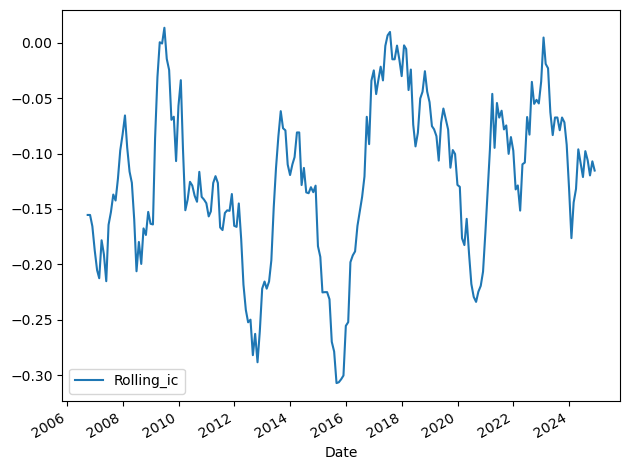

In [17]:
Ave_returns.loc[0:228].plot(x='Date',y=['Rolling_ic'])

plt.tight_layout()
plt.show()

In [18]:
Overall_ic

-0.12348992222391397